<a href="https://colab.research.google.com/github/iceman011/mydeeplearning/blob/master/ez-mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import time
from datetime import datetime as dt
import datetime
import os
import pdb

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
  
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from torch import optim
import itertools
#!/usr/bin/env python3
import mmap
import re
from itertools import dropwhile, product

import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers,output_classes,transform,dataset, drop_p=0.5,lr =0.001, train_on_gpu=False):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        
        '''
        super().__init__()
        if train_on_gpu:
          # check if CUDA is available
          self.train_on_gpu = torch.cuda.is_available()

        if not self.train_on_gpu:
            print('CUDA is not available.  Using CPU ...')
        else:
            print('CUDA is available!  Using GPU ...')
            
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = lr
        self.drop_ratio = drop_p
        self.output_classes = output_classes
        self.transform=transform
        self.dataset=dataset

        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)



######################    
# LOADING DATA #
######################
def LoadData(datasetName,batch_size=20,valid_size = 0.2):
      
    # number of subprocesses to use for data loading
    num_workers = 0


    # convert data to torch.FloatTensor
    #transform = transforms.ToTensor()

    # convert data to a normalized torch.FloatTensor
    transform = None
    train_data= None
    test_data=None
    classes=None
    if(datasetName == 'MINST'):
       # convert data to a normalized torch.FloatTensor
      transform = transforms.Compose([
          transforms.RandomHorizontalFlip(), # randomly flip and rotate
          #transforms.RandomRotation(10),
          transforms.CenterCrop(224),          
          transforms.ToTensor(),
          transforms.Normalize((0.5, ), (0.5, ))
          ])
      
      # choose the training and test datasets
      train_data = datasets.MNIST(root='data', train=True,
                                        download=True, transform=transform)
      test_data = datasets.MNIST(root='data', train=False,
                                        download=True, transform=transform)
      # specify the image classes
      classes = ['1', '2', '3', '4', '5',
           '6', '7', '8', '9', '10']
    elif(datasetName == 'CIFAR'):
      
      # convert data to a normalized torch.FloatTensor
      transform = transforms.Compose([
          transforms.RandomHorizontalFlip(), # randomly flip and rotate
          transforms.RandomRotation(10),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
          ])
      
      # choose the training and test datasets
      train_data = datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=transform)
      test_data = datasets.CIFAR10(root='data', train=False,
                                        download=True, transform=transform)
      # specify the image classes
      classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
        sampler=train_sampler, num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
        sampler=valid_sampler, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
        num_workers=num_workers)
    return train_loader , valid_loader ,test_loader ,classes , transform


#############################
# VALIDATE MODEL
############################
def validation(model, validationloader, criterion):
    accuracy = 0
    validation_loss = 0
    validate_start_time = time.time()

    print(dt.now().strftime("%d_%b_%Y_%H_%M_%S")+' : ','Starting Validation....')

    with torch.no_grad():    
      # move tensors to GPU if CUDA is available
      if model.train_on_gpu:
        model.cuda()

      for images, labels in validationloader:

          if model.train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
          
          images = images.resize_(images.size()[0], model.input_size)

          output = model.forward(images)
          validation_loss += criterion(output, labels).item()

          ## Calculating the accuracy 
          # Model's output is log-softmax, take exponential to get the probabilities
          ps = torch.exp(output)
          # Class with highest probability is our predicted class, compare with true label
          #equality = (labels.data == ps.max(1)[1])
          # Accuracy is number of correct predictions divided by all predictions, just take the mean
          #accuracy += equality.type_as(torch.FloatTensor()).mean()


        
          top_p, top_class = ps.topk(1, dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))      
        
      validation_loss = validation_loss/len(validationloader)
      accuracy = 100. * accuracy/len(validationloader)
    
    print('Finished Validation In ',datetime.timedelta(seconds = time.time() - validate_start_time) )
    return validation_loss, accuracy

#############################
# TEST MODEL
############################
def test(model,test_loader,criterion,checkpoint,outputfilepath,batch_size,override_checkpoint):
    # track test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(model.output_size))
    class_total = list(0. for i in range(model.output_size))
    test_start_time = time.time()

    print(dt.now().strftime("%d_%b_%Y_%H_%M_%S")+' : Starting Testing....')
    # move tensors to GPU if CUDA is available
    if model.train_on_gpu:
      model.cuda()

    with torch.no_grad():    
      model.eval()
      # iterate over test data
      for data, target in test_loader:
          # move tensors to GPU if CUDA is available
          if model.train_on_gpu:
              data, target = data.cuda(), target.cuda()
          
          # Flatten images into a 784 long vector
          data.resize_(data.size()[0], model.input_size)

          # forward pass: compute predicted outputs by passing inputs to the model
          output = model(data)
          # calculate the batch loss
          loss = criterion(output, target)
          # update test loss 
          test_loss += loss.item()*data.size(0)
          # convert output probabilities to predicted class
          _, pred = torch.max(output, 1)    
          # compare predictions to true label
          correct_tensor = pred.eq(target.data.view_as(pred))
          correct = np.squeeze(correct_tensor.numpy()) if not model.train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
          # calculate test accuracy for each object class
          for i in range(batch_size):
              label = target.data[i]
              class_correct[label] += correct[i].item()
              class_total[label] += 1

      # average test loss
      print('Finished Testing during ',datetime.timedelta(seconds=time.time() - test_start_time))
      test_loss = test_loss/len(test_loader.dataset)
      print('Test Loss: {:.6f}\n'.format(test_loss))
      
      test_checkpoint = dict()

      if(override_checkpoint):
        checkpoint.update({'TestLoss': test_loss})
      else :
        test_checkpoint.update({'TestLoss': test_loss})

      for i in range(model.output_size):
          if class_total[i] > 0:
            current_key  = 'Test Accuracy of '+model.output_classes[i]
            current_val = '{:.3f}% ({}/{})'.format(100 *( class_correct[i] / class_total[i]),
                  np.sum(class_correct[i]), np.sum(class_total[i]))
            ele={current_key:current_val}
            if(override_checkpoint):
              checkpoint.update(ele)
              print(current_key,current_val)
            else:
              test_checkpoint.update(ele)


          """else:
              print('Test Accuracy of %5s: N/A (no training examples)' % (model.output_classes[i]))
          """

      current_key = 'Test Accuracy (Overall): '#.format(100. * np.sum(class_correct) / np.sum(class_total))
      current_val = '{:.3f}% ({}/{})'.format(100 * (np.sum(class_correct) / np.sum(class_total)),
          np.sum(class_correct), np.sum(class_total) )
      ele={current_key:current_val}
      if(override_checkpoint):
        checkpoint.update(ele)      
        print(current_key,current_val)
      else:
        test_checkpoint.update(ele)
        test_checkpoint.update({'Detailed ':checkpoint})

    
    #model.train()
    if(override_checkpoint):
      print('Overriding Checkpoint')
      torch.save(checkpoint,outputfilepath)

    return checkpoint , test_checkpoint

#############################
# TRAIN MODEL
############################
def train(model, trainloader, validationloader, criterion, optimizer, uploadToGDrive,checkpointPath,PreviousCheckPointId,
          PreviousValidationLoss,start_time,exp_id,epochs=5, print_every=40):
    # monitor training loss    
    steps = 0    
    #start_time = time.time()
    #dateTimeObj = datetime.now()
    #start_time_timestamp = './results/'+dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")
    #start_time_timestamp = dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")
    train_losses, valid_losses = [], []
    checkpoint = dict()

    # move tensors to GPU if CUDA is available
    if model.train_on_gpu:
      model.cuda()

    print(dt.now().strftime("%d_%b_%Y_%H_%M_%S")+' : Starting Training using Model Parameters \n '+str(model)+' \n from PreviousModel '+ PreviousCheckPointId + ' with validationLoss '+ str(PreviousValidationLoss) )
    valid_loss_min = PreviousValidationLoss #np.Inf # set initial "min" to infinity

    for e in range(epochs):        
        train_loss = 0.0
        valid_loss = 0.0
        epoch_start_time = time.time()

        print(dt.now().strftime("%d_%b_%Y_%H_%M_%S")+' : Starting Training of Epoch'+str(e)  )
        ###################
        # train the model #
        ###################
        model.train() # prep model for training

        for images, labels in trainloader:
            steps += 1
            
            # move tensors to GPU if CUDA is available
            if model.train_on_gpu:
              images, labels = images.cuda(), labels.cuda()

            # Flatten images into a 784 long vector
            images.resize_(images.size()[0], model.input_size)
            
            optimizer.zero_grad()
            
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

        train_loss = train_loss/len(trainloader.sampler)
        train_losses.append(train_loss)
        ######################    
        # validate the model #
        ######################
        # Model in inference mode, dropout is off
        model.eval()
        print(' Finished Training of Epoch '+str(e),' In ',datetime.timedelta(seconds = time.time() - epoch_start_time) )

        # Turn off gradients for validation, will speed up inference
        with torch.no_grad():
            valid_loss, accuracy = validation(model, validationloader, criterion)
        
        valid_losses.append(valid_loss)

        print('{} : Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy : {:.6f}'.format(
            dt.now().strftime("%d_%b_%Y_%H_%M_%S"),
            e+1, 
            train_loss,
            valid_loss,
            accuracy
            ))
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f} ,)  Accuracy: {:.6f}  TimeElapsed: {:.6f}.  Saving model ...'.format(
            valid_loss_min,
            valid_loss,
            accuracy,
            (time.time() - start_time)))
            
            

            checkpoint = {'InputSize': model.input_size,
                  'OutputSize': model.output_size,
                  'HiddenLayers': [each.out_features for each in model.hidden_layers],
                  'LearningRate':model.learning_rate,
                  'DropRatio':model.drop_ratio,
                  'TrainingLoss' :train_loss,
                  'ValidationLoss':valid_loss,
                  'ValidationAccuracy':accuracy,
                  'ElapsedTime': datetime.timedelta(seconds = time.time() - start_time),
                  'Dataset':model.dataset,
                  'LastEpoch': e,
                  'PreviousCheckPoint': PreviousCheckPointId,
                  'GPUState': model.train_on_gpu,                  
                  'OutputFolder' : exp_id,
                  'CheckPointTimestamp': dt.now().strftime("%d_%b_%Y_%H_%M_%S"), #time.time(),
                  'OutputFilePrefix' : 'checkpoint_',
                  'OutputClasses': model.output_classes,
                  'Transforms': model.transform,
                  'TrainingLosses' :train_losses,
                  'ValidationLosses':valid_losses,
                  'StateDictionay': model.state_dict()}
            
            #print(checkpoint)
            save_model(checkpoint,uploadToGDrive,checkpointPath)
            valid_loss_min = valid_loss

    return train_losses , valid_losses , checkpoint


#############################
# SAVE MODEL TO GOOGLE DRIVE
############################
def save_model(checkpoint,uploadToGDrive,checkpointPath):
  
  file_path = ''
  if(uploadToGDrive):
    drive.mount('/content/gdrive')
    file_path = checkpointPath+checkpoint['OutputFolder']
    if not os.path.exists(file_path):
      os.makedirs(file_path)      
    #path = f'/content/gdrive/My Drive/Colab Notebooks/models/'+dataset+'/'+checkpoint['OutputFolder']+'_'+str(checkpoint['LastEpoch'])+'.pt'
    print('Saving Model to ',file_path +'/'+checkpoint['OutputFilePrefix']+str(checkpoint['CheckPointTimestamp'])+'_'+str(checkpoint['LastEpoch'])+'.pt')
    torch.save(checkpoint, file_path +'/'+checkpoint['OutputFilePrefix']+str(checkpoint['CheckPointTimestamp'])+'_'+str(checkpoint['LastEpoch'])+'.pt')
  else:
    file_path=checkpointPath+checkpoint['OutputFolder']
    if not os.path.exists(file_path):
      os.makedirs(file_path)
    
    print('Saving Model to ',file_path+'/'+checkpoint['OutputFilePrefix']+str(checkpoint['CheckPointTimestamp'])+'_'+str(checkpoint['LastEpoch'])+'.pt')
    torch.save(checkpoint, file_path+'/'+checkpoint['OutputFilePrefix']+str(checkpoint['CheckPointTimestamp'])+'_'+str(checkpoint['LastEpoch'])+'.pt')


###########################
# SKIP CERTAIN ENTERIES FROM ITERTOOLS.PRODUCT
#####################33
def resume(iterable, sentinel):
    yield from dropwhile(lambda x: x != sentinel, iterable)

#############################
# LOAD LAST EXPERIMENT PARAMS
##################################
def load_last_exp_param(logPath,checkpointPath):

  #with open(checkpointPath+'/3-3-2020.txt') as f:
  #    total = f.read()
  #    print( total.count('Starting New') )
      
  f = open(logPath, 'r')
  content = f.read()

  hidden_layers = re.findall('hidden_layers: \{(.+?)\}', content)
  hidden_layers = int(hidden_layers[len(hidden_layers)-1])

  hidden_layer_width = re.findall('hidden_layer_width: \{(.+?)\}', content)
  hidden_layer_width = hidden_layer_width[len(hidden_layer_width)-1]

  Learning_rate = re.findall('Learning_Rate: \{(.+?)\}', content)
  Learning_rate = float(Learning_rate[len(Learning_rate)-1])

  drop_ratio = re.findall('drop_ratio: \{(.+?)\}', content)
  drop_ratio = float(drop_ratio[len(drop_ratio)-1])
  prev_valid_loss = np.Inf
  return_checkpoint = None
  return_model = None

  #for filename in os.listdir(checkpointPath):
  for root, dirs, files in os.walk(checkpointPath):
    for filename in files:
      model , checkpoint , filepath = load_checkpoint(root,filename[:filename.rfind('_')+1],False,filename[filename.rfind('_')+1:filename.rfind('.')],load_model=True)
      if( float(checkpoint['ValidationLoss']) < prev_valid_loss ):
        prev_valid_loss = checkpoint['ValidationLoss']
      
      
      #pdb.set_trace()
      hidden_layer_width_local = hidden_layer_width.strip()
      hidden_layer_width_local = hidden_layer_width_local[1:len(hidden_layer_width_local)-1]
      hidden_layer_width_local = list(map(int, hidden_layer_width_local.split(',')))

      if(hidden_layer_width_local == checkpoint['HiddenLayers'] and float(checkpoint['ValidationLoss']) <= prev_valid_loss ):
        print(' Found Matching Checkpoint with Last Experiement Parameters hidden_layers:{}  hidden_layer_width:{} Learning_rate:{} drop_ratio:{} '.format(hidden_layers,hidden_layer_width,Learning_rate,drop_ratio))
        return_checkpoint = checkpoint
        return_model = model
        prev_valid_loss = checkpoint['ValidationLoss']
        #return checkpoint,model,hidden_layers,hidden_layer_width,Learning_rate,drop_ratio,prev_valid_loss

  if( not bool(return_checkpoint)): 
    print(' Not Found Matching Checkpoint with Last Experiement Parameters hidden_layers:{}  hidden_layer_width:{} Learning_rate:{} drop_ratio:{} '.format(hidden_layers,hidden_layer_width,Learning_rate,drop_ratio))    

  return return_checkpoint,return_model,hidden_layers,hidden_layer_width,Learning_rate,drop_ratio,prev_valid_loss


################################
# TUNE NETWORK LAYERS AND NO. OF NODES
##################################
def tune_train_network(dataset,epochs,resumeExp=False,resume_logPath='',resume_checkpointPath=''):

  start_time = time.time()
  dateTimeObj = dt.now()
  exp_id = dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")

  #How many samples loaded per batch
  batch_size = 20
  # percentage of training set to use as validation
  valid_size = 0.2
  #dataset = 'MINST'
  checkpointPath = f'/content/gdrive/My Drive/Colab Notebooks/models/'+dataset+'/'
  #checkpointPath = f'./results/'+dataset+'/'

  #train_loader =None
  #valid_loader =None
  #Load Data
  
  train_loader , valid_loader ,test_loader , classes , transform = LoadData(dataset,batch_size,valid_size)

  nodes_per_layer =  [2048, 1024, 512, 256, 128, 64, 32]
  full_learning_rates= [0.1, 0.01, 0.0001, 0.001]
  full_drop_ratios= [0.8, 0.5, 0.3, 0.1]
  learning_rates = None
  drop_ratios = None
  PreviousValidationLoss= np.Inf
  max_hidden_layers = 3
  iter_hidden_layer_nodes = None
  iter_hidden_layer_nodes_list = None
  model = None

  if(resumeExp):
    print(dt.now().strftime("%d_%b_%Y_%H_%M_%S")+' : Resuming Experiment With New ID ',exp_id )
    resume_checkpoint,model,resum_hidden_layers,resume_hidden_layer_width,resume_Learning_rate,resume_drop_ratio,resume_prev_valid_loss =  load_last_exp_param(resume_logPath,resume_checkpointPath)
    max_hidden_layers = resum_hidden_layers  

    learning_rates = full_learning_rates[full_learning_rates.index(resume_Learning_rate):]
    drop_ratios = full_drop_ratios[full_drop_ratios.index(resume_drop_ratio):]
    PreviousValidationLoss = resume_prev_valid_loss
    checkpointPath = resume_checkpointPath

      #iter_hidden_layer_nodes = resume(itertools.product(nodes_per_layer, repeat=hidden_layers+1), resume_checkpoint['HiddenLayers'])      
    #if(bool(resume_checkpoint)):
    #  model , resume_checkpoint , filepath = load_checkpoint(checkpointPath,filename[:filename.rfind('_')+1],False,filename[filename.rfind('_')+1:filename.rfind('.')])
      


  #VARY HIDDEN LAEYERS
  for hidden_layers in range(max_hidden_layers,0,-1):
    #VARY HIDDEN LAYER NODES/WIDTH
    if(resumeExp ):
      iter_hidden_layer_nodes = itertools.product(nodes_per_layer, repeat= hidden_layers)
      iter_hidden_layer_nodes_list = [item for item in iter_hidden_layer_nodes]
      resume_hidden_layer_width = resume_hidden_layer_width[1:len(resume_hidden_layer_width)-1]
      
      #pdb.set_trace()
      resume_hidden_layer_width = resume_hidden_layer_width[1:len(resume_hidden_layer_width)-1]
      resume_hidden_layer_width_list = tuple(list(map(int, resume_hidden_layer_width.split(','))))
      iter_hidden_layer_nodes_list = iter_hidden_layer_nodes_list[iter_hidden_layer_nodes_list.index(resume_hidden_layer_width_list):]
      
      print('Resume ValidationLoss ',PreviousValidationLoss,'Resume Learning Rate Array ',learning_rates ,' Resume Drop Ratio List ',drop_ratios , ' Resume Hidden Nodes List ',iter_hidden_layer_nodes_list )
    else:      
      iter_hidden_layer_nodes = itertools.product(nodes_per_layer, repeat=hidden_layers+1)
      iter_hidden_layer_nodes_list = [item for item in iter_hidden_layer_nodes]
    for hidden_layer in iter_hidden_layer_nodes_list:
      #VARY LEARNING RATE
      if( not resumeExp):
        learning_rates = full_learning_rates
      for lr in learning_rates :
        #VARY DROP RATIO
        if( not resumeExp):
          drop_ratios = full_drop_ratios
        for drop_ratio in drop_ratios :
          
          print(exp_id+':  DurationSinceStart :',datetime.timedelta(seconds = time.time() - start_time),' Starting New Experiment with %hidden_layers: {',hidden_layers,'}% %hidden_layer_width: {',hidden_layer ,'}% %Learning_Rate: {',lr, '}% %drop_ratio: {',drop_ratio,'}%')
          #model = Network(784, 10, [first_layer, second_layer, third_layer ],classes,transform,dataset, lr=0.001,train_on_gpu=True)
          if( not bool(resume_checkpoint) or not resumeExp ):
            model = Network(784, 10, hidden_layer ,classes,transform,dataset,drop_p=drop_ratio,lr =lr,train_on_gpu=True)

          criterion = nn.NLLLoss()
          optimizer = optim.Adam(model.parameters(), lr=lr)


          #Upload checkpoint to local drive
          #train_lossess , valid_lossess , checkpointt = train(model, train_loader, valid_loader, criterion, optimizer, False,checkpointPath,PreviousCheckPointId,PreviousValidationLoss,epochs=100)

          #Upload to gDrive
          train_lossess , valid_lossess , checkpointt = train(model, train_loader, valid_loader, criterion, optimizer, True,checkpointPath,'',PreviousValidationLoss,start_time,exp_id,epochs=epochs)
          if( bool(checkpointt) and checkpointt['ValidationLoss'] < PreviousValidationLoss ):
            PreviousValidationLoss = checkpointt['ValidationLoss']
        
        #pdb.set_trace()
        resumeExp=False


#############################
# PLOT TRAINING LOSS VS VALIDATION LOSS 
############################
def plotLossTrend(train_losses,validation_losses,test_losses=[]):
  #TRAINING LOSS DATA
  values = []
  labels = []
  for item in train_losses:    
    for key, value in item.items():
      values.append("{0:.5f}".format(value)) #= train_losses[:1] #[7, 57, 121, 192, 123, 240, 546]
      labels.append(key) #= train_losses[:0] #['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']


  plt.figure(figsize = (12,12))   
  plt.plot(labels,values,label='Training Loss')
  for i,j in zip(labels,values):
      plt.annotate(str(j),xy=(i,j))
  
  plt.xticks(rotation=90)
  #plt.show()

  #VALIDATON LOSS
  values = []
  labels = []
  for item in validation_losses:   
    #pdb.set_trace() 
    for key, value in item.items():      
      values.append("{0:.5f}".format(value)) #= train_losses[:1] #[7, 57, 121, 192, 123, 240, 546]
      labels.append(key) #= train_losses[:0] #['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']


  #plt.figure(figsize = (12,12))   
  plt.plot(labels,values,label='Validation Loss')
  for i,j in zip(labels,values):
      plt.annotate(str(j),xy=(i,j))
  
  plt.xticks(rotation=90)
  #plt.show()

  #TEST LOSS
  values = []
  labels = []
  for item in test_losses:    
    for key, value in item.items():
      #pdb.set_trace()
      values.append("{0:.5f}".format(value)) #= train_losses[:1] #[7, 57, 121, 192, 123, 240, 546]
      labels.append(key) #= train_losses[:0] #['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']


  #plt.figure(figsize = (12,12))   
  plt.plot(labels,values,label='Test Loss')
  for i,j in zip(labels,values):
      plt.annotate(str(j),xy=(i,j))
  
  plt.xticks(rotation=90)
  plt.show()
  #for i, v in enumerate(values):
  #    ax.text(i, v+25, "%d" %v, ha="center")
  #plt.ylim(-10, 595)

#############################
# LOAD CHECKPOINT
############################
def load_checkpoint(OutputFolder,OutputFilePrefix,max_epoch,exact_epoch,load_model=True):
    
    file_epoch = 0
    if(max_epoch):
      for filename in os.listdir(OutputFolder):
        data = filename.split('_')
        tmp=int(data[1][:-3])
        #print('data[1]',data[1],' tmp[:-3] ',tmp[:-3])
        if( file_epoch <= tmp ):
          file_epoch = tmp
    else:
      file_epoch=exact_epoch

    filepath = OutputFolder+'/'+OutputFilePrefix + str(file_epoch)+'.pt'
    print('Loading Checkpoint from '+filepath+'...')
    indent=1
    checkpoint = torch.load(filepath)
    for key, value in checkpoint.items():
        if(key == 'StateDictionay'):
          continue
        print('\t' * indent + str(key),'\t' * (indent+1) + str(value))
        #print('\t' * (indent+1) + str(value))
    
    testmodel = None

    if(load_model):
      testmodel = Network(checkpoint['InputSize'],
                              checkpoint['OutputSize'],
                              checkpoint['HiddenLayers'],
                              checkpoint['OutputClasses'],
                              checkpoint['Transforms'],
                              checkpoint['Dataset'],
                              checkpoint['DropRatio'],
                              checkpoint['LearningRate'],
                              train_on_gpu=checkpoint['GPUState']
                      )
      testmodel.load_state_dict(checkpoint['StateDictionay'])
      
    return testmodel , checkpoint , filepath


def test_all_epochs(OutputFolder,test_loader,criterion,batch_size,OutputFilePrefix='checkpoint_'):

    #OutputFolder = './results/'
    file_epoch = 0
    result_list=[]
    print('Starting Test All Saved Epochs ....')
    trainig_loss=[]
    validation_loss=[]
    test_loss=[]
    ele = dict()

    """
        for folder in os.listdir(OutputFolder):
          for filename in os.listdir(OutputFolder+folder):
            data = filename.split('_')
            #pdb.set_trace()
            print(data)
            file_epoch=int(data[1][:-3])

            model , checkpoint , filepath = load_checkpoint(OutputFolder+folder,OutputFilePrefix,False,file_epoch)
    """
    #for filename in os.listdir(checkpointPath):
    for root, dirs, files in os.walk(OutputFolder):
      for filename in files:
        model , checkpoint , filepath = load_checkpoint(root,filename[:filename.rfind('_')+1],False,filename[filename.rfind('_')+1:filename.rfind('.')],load_model=True)

        checkpoint , checkpoint_test = test(model,test_loader,criterion,checkpoint,filepath,batch_size,False)

        print('Test Accuracy ',checkpoint_test['Test Accuracy (Overall): '])
        result_list.append(checkpoint_test)

        #ele = [list() for f in range(1)] # We have Three Empty Rows
        #ele[0].append(checkpoint['Dataset']+'_'+checkpoint['OutputFolder']+'_'+str(checkpoint['LastEpoch']))
        #ele[0].append(checkpoint['TrainingLoss'])
        key = checkpoint['Dataset'] + '_' + checkpoint['OutputFolder'] + '_' + str(checkpoint['LastEpoch'])
        ele = {key: checkpoint['TrainingLoss']}
        trainig_loss.append(ele)
        
        #ele = [list() for f in range(1)] # We have Three Empty Rows
        #ele[0].append(checkpoint['Dataset']+'_'+checkpoint['OutputFolder']+'_'+str(checkpoint['LastEpoch']))
        #ele[0].append(checkpoint['ValidationLoss'])
        ele = {}
        ele ={key: checkpoint['ValidationLoss']}
        validation_loss.append(ele)

        #ele = [list() for f in range(1)] # We have Three Empty Rows
        #ele[0].append(checkpoint['Dataset']+'_'+checkpoint['OutputFolder']+'_'+str(checkpoint['LastEpoch']))
        #ele[0].append(checkpoint_test['TestLoss'])
        ele = {}
        ele ={key: checkpoint_test['TestLoss']}
        test_loss.append(ele)
    
    #print('Result List',result_list)
    plotLossTrend (trainig_loss,validation_loss,test_loss)
    return result_list
      

#############################
# VISUALIZE ALL IMAGES IN BATCH
############################
def visualize_images_in_batch(loader,batch_size) :
    # obtain one batch of training images
		dataiter = iter(loader)
		images, labels = dataiter.next()
		images = images.numpy()

		# plot the images in the batch, along with the corresponding labels
		fig = plt.figure(figsize=(25, 4))
		for idx in np.arange(batch_size):
			ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
			ax.imshow(np.squeeze(images[idx]), cmap='gray')
			# print out the correct label for each image
			# .item() gets the value contained in a Tensor
			ax.set_title(str(labels[idx].item()))
		return images


#############################
# VISUALIZE PIXEL OF AN IMAGE RETURN FROM PREV FUNCTION
############################
def visualize_image_pixels_value(image):

  img = np.squeeze(image)
  fig = plt.figure(figsize = (12,12)) 
  ax = fig.add_subplot(111)
  ax.imshow(img, cmap='gray')
  width, height = img.shape
  thresh = img.max()/2.5
  for x in range(width):
      for y in range(height):
          val = round(img[x][y],2) if img[x][y] !=0 else 0
          ax.annotate(str(val), xy=(y,x),
                      horizontalalignment='center',
                      verticalalignment='center',
                      color='white' if img[x][y]<thresh else 'black')

def visualize_rgb_image_pixels_value(image):
  rgb_img = np.squeeze(image)
  channels = ['red channel', 'green channel', 'blue channel']

  fig = plt.figure(figsize = (36, 36)) 
  for idx in np.arange(rgb_img.shape[0]):
      ax = fig.add_subplot(1, 3, idx + 1)
      img = rgb_img[idx]
      ax.imshow(img, cmap='gray')
      ax.set_title(channels[idx])
      width, height = img.shape
      thresh = img.max()/2.5
      for x in range(width):
          for y in range(height):
              val = round(img[x][y],2) if img[x][y] !=0 else 0
              ax.annotate(str(val), xy=(y,x),
                      horizontalalignment='center',
                      verticalalignment='center', size=8,
                      color='white' if img[x][y]<thresh else 'black')

def visualize_test_results(model,test_loader,batch_size,RGB=False):
  # obtain one batch of test images
  dataiter = iter(test_loader)
  images, labels = dataiter.next()
  images.numpy()

  # move model inputs to cuda, if GPU available
  if model.train_on_gpu:
      images = images.cuda()

  # Flatten images into a 784 long vector
  images.resize_(images.size()[0], model.input_size)

  # get sample outputs
  output = model(images)
  # convert output probabilities to predicted class
  _, preds_tensor = torch.max(output, 1)
  preds = np.squeeze(preds_tensor.numpy()) if not model.train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

  # plot the images in the batch, along with predicted and true labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(batch_size):
      ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])

      image_cpu = images.cpu()[idx]
      image_cpu = image_cpu / 2 + 0.5  # unnormalize
      if(RGB):
        plt.imshow(np.transpose(image_cpu, (1, 2, 0)))  # convert from Tensor image
      else:
        ax.imshow(np.squeeze(image_cpu), cmap='gray')

      ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                  color=("green" if preds[idx]==labels[idx].item() else "red"))

In [33]:
############################# TUNE NETWORK ####################################3

drive.mount("/content/gdrive", force_remount=True)

#tune_train_network(resumeExp=True,resume_logPath='/content/gdrive/My Drive/Colab Notebooks/models/MINST/logs/3-6-2020.txt',resume_checkpointPath='/content/gdrive/My Drive/Colab Notebooks/models/MINST/06_Mar_2020_07_57_24/')
#tune_train_network('MINST',10,resumeExp=False,resume_logPath='/content/gdrive/My Drive/Colab Notebooks/models/MINST/logs/resume-3-6-2020.txt',resume_checkpointPath='/content/gdrive/My Drive/Colab Notebooks/models/MINST/06_Mar_2020_07_57_24/')

#load_last_exp_param('/content/gdrive/My Drive/Colab Notebooks/models/MINST/logs/3-6-2020.txt','/content/gdrive/My Drive/Colab Notebooks/models/MINST/06_Mar_2020_07_57_24/')

!python -u /content/ezz-mlp.py 2>&1 | tee -a '/content/gdrive/My Drive/Colab Notebooks/models/MINST/logs/resume-3-6-2020.txt' #2>&1


#load_last_exp_param('/content/gdrive/My Drive/Colab Notebooks/models/MINST/logs','/content/gdrive/My Drive/Colab Notebooks/models/MINST/04_Mar_2020_20_13_34')

Mounted at /content/gdrive
/usr/local/lib/python3.6/dist-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
07_Mar_2020_17_45_38 : Resuming Experiment With New ID  07_Mar_2020_17_45_38
Loading Checkpoint from /content/gdrive/My Drive/Colab Notebooks/models/MINST/06_Mar_2020_07_57_24//checkpoint_06_Mar_2020_07_57_57_0.pt...
	InputSize 		784
	OutputSize 		10
	HiddenLayers 		[1024, 1024, 1024, 1024]
	LearningRate 		0.1
	DropRatio 		0.8
	TrainingLoss 		25.76125770568351
	ValidationLoss 		2.306779959599177
	ValidationAccuracy 		tensor(9.9417)
	ElapsedTime 		33.66304087638855
	Dataset 		MINST
	LastEpoch 		0
	PreviousCheckPoint 		
	GPUState 		True
	OutputFolder 		06_Mar_2020_07_57_24
	CheckPointTimestamp 		06_Mar_2020_07_57_57
	OutputFilePrefix 		checkpoint_
	OutputClasses 		['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
	Transforms 		Compose(

Mounted at /content/gdrive
Starting Test All Saved Epochs ....
Loading Checkpoint from /content/gdrive/My Drive/Colab Notebooks/models/MINST/06_Mar_2020_07_57_24//checkpoint_06_Mar_2020_07_57_57_0.pt...
	InputSize 		784
	OutputSize 		10
	HiddenLayers 		[1024, 1024, 1024, 1024]
	LearningRate 		0.1
	DropRatio 		0.8
	TrainingLoss 		25.76125770568351
	ValidationLoss 		2.306779959599177
	ValidationAccuracy 		tensor(9.9417)
	ElapsedTime 		33.66304087638855
	Dataset 		MINST
	LastEpoch 		0
	PreviousCheckPoint 		
	GPUState 		True
	OutputFolder 		06_Mar_2020_07_57_24
	CheckPointTimestamp 		06_Mar_2020_07_57_57
	OutputFilePrefix 		checkpoint_
	OutputClasses 		['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
	Transforms 		Compose(
    RandomHorizontalFlip(p=0.5)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)
	TrainingLosses 		[25.76125770568351]
	ValidationLosses 		[2.306779959599177]
CUDA is available!  Using GPU ...
07_Mar_2020_19_54_44 : Starting Test

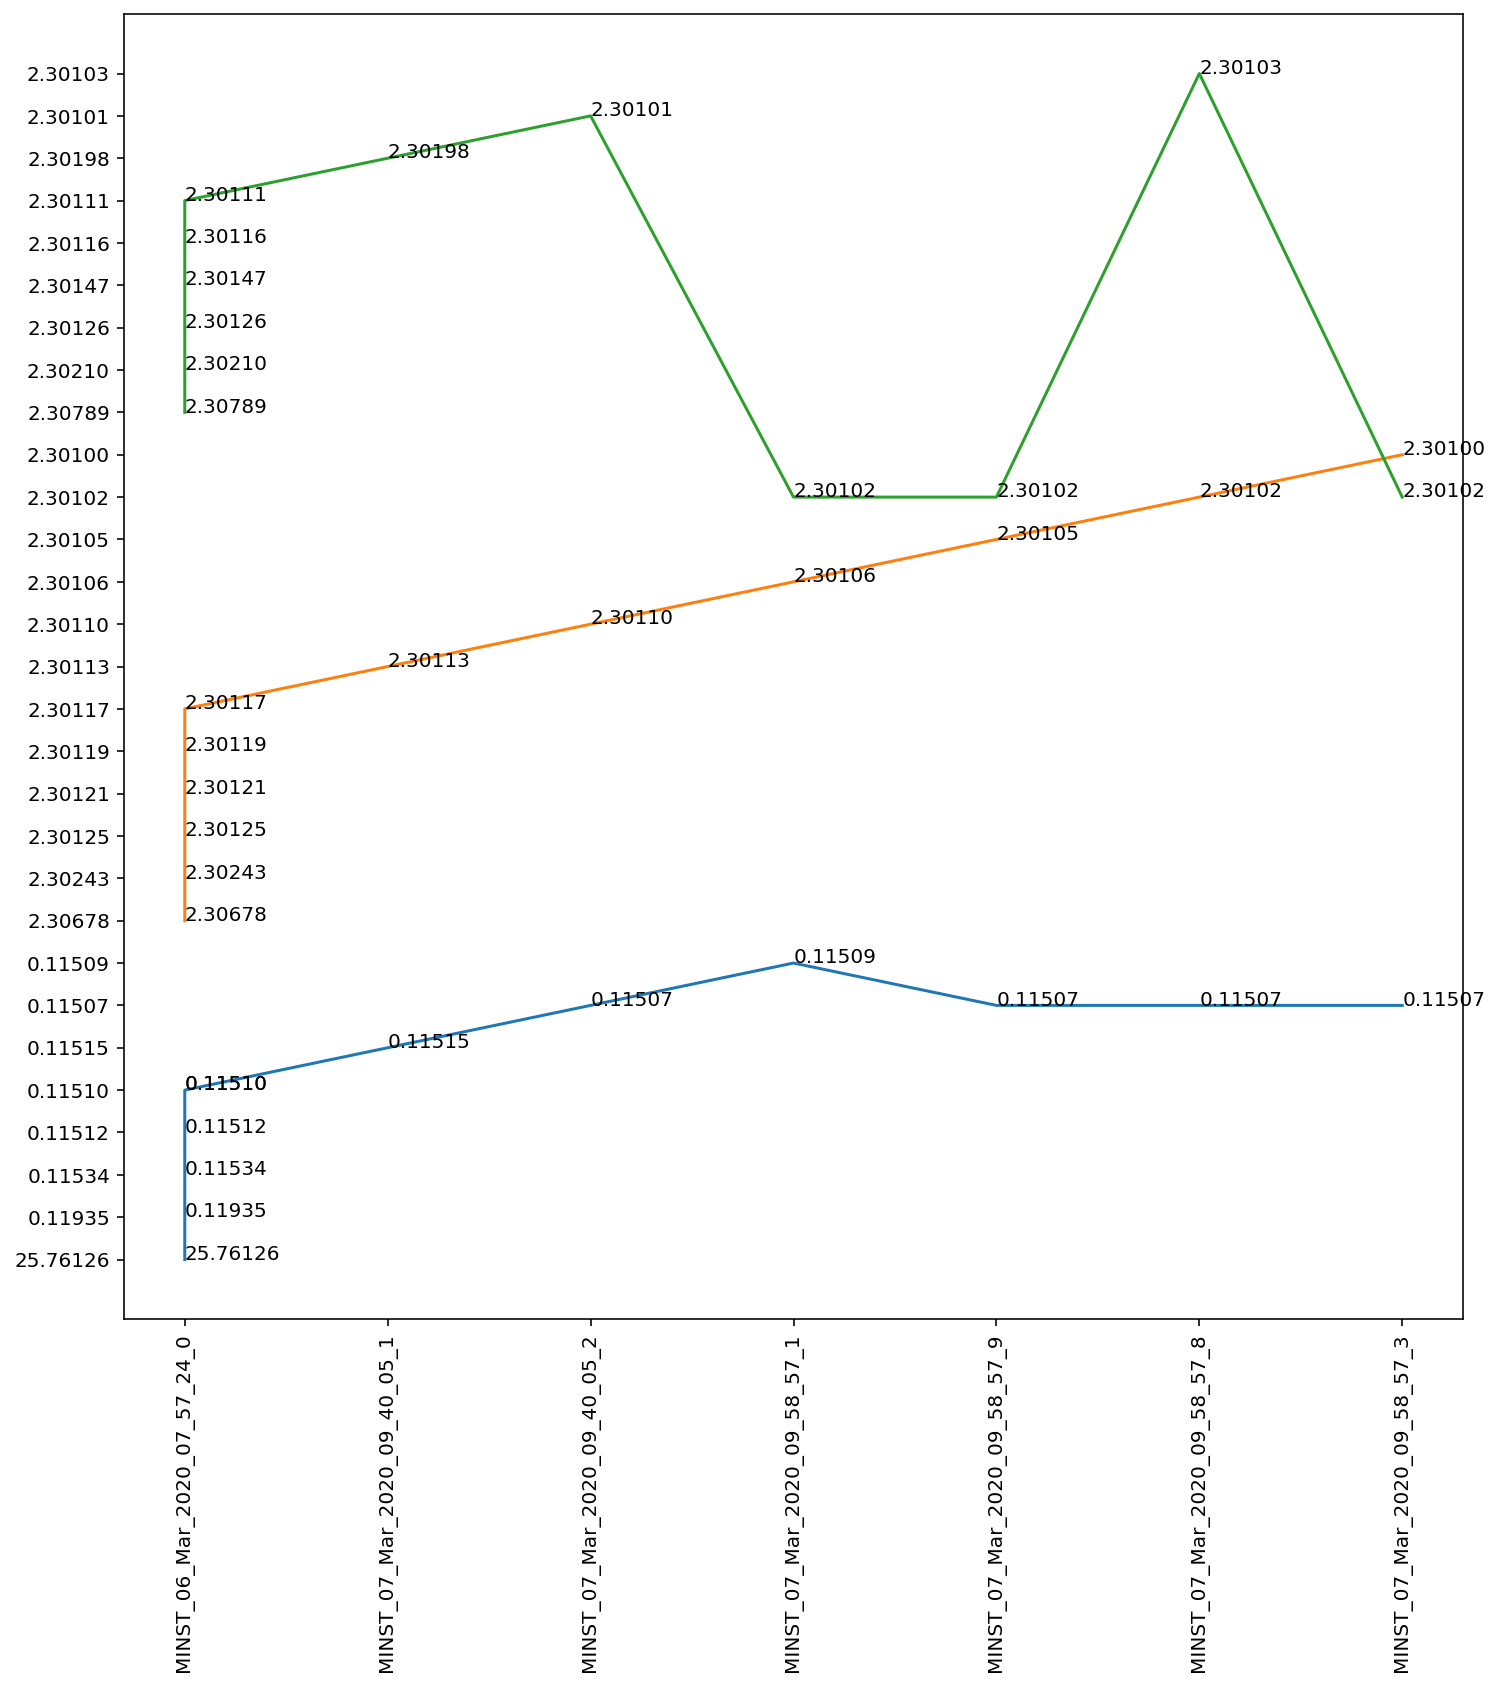

In [18]:
########################### TEST ALL EPOCHS ##############################


#model , checkpointtt , filepathh = load_checkpoint(checkpointttt['OutputFolder'],checkpointttt['OutputFilePrefix'],False,10)

#result_list = test_all_epochs(test_loader,criterion,batch_size)

dataset = 'MINST'


#How many samples loaded per batch
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

#train_loader =None
#valid_loader =None
#Load Data
dataset = 'MINST'
train_loader , valid_loader ,test_loader , classes , transform = LoadData(dataset,batch_size,valid_size)


drive.mount("/content/gdrive", force_remount=True)
gfolder = '/content/gdrive/My Drive/Colab Notebooks/models/MINST/06_Mar_2020_07_57_24/'

localfolder = './results/'+dataset+'/'

result_list = test_all_epochs(gfolder,test_loader,nn.NLLLoss(),batch_size,OutputFilePrefix='checkpoint_')

#checkpoint = torch.load('/content/drive/My Drive/Colab Notebooks/models/minst/29_Feb_2020_20_06_50_74.pt')

#print(checkpoint)
#load_checkpoint('/gdrive/My Drive/Colab Notebooks/models/'+dataset,'29_Feb_2020_20_06_50',False,74)




In [0]:

######################    
# MAIN #
######################

# Create the network, define the criterion and optimizer
drive.mount("/content/gdrive", force_remount=True)

#CONTINUE FROM PREVIOUS MODEL
#model , checkpoint , filepath = load_checkpoint('/content/drive/My Drive/Colab Notebooks/models/MINST/01_Mar_2020_18_42_35','checkpoint_',True,0)
#PreviousCheckPointId = checkpoint['OutputFolder']+'_'+str(checkpoint['LastEpoch'])
#PreviousValidationLoss= checkpoint['ValidationLoss'] #np.Inf

model = Network(784, 10, [512, 256, 128 , 64 ],classes,transform,dataset, lr=0.001,train_on_gpu=True)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

checkpointPath = f'/content/gdrive/My Drive/Colab Notebooks/models/'+dataset+'/'
#checkpointPath = f'./results/'+dataset+'/'



#Upload checkpoint to local drive
#train_lossess , valid_lossess , checkpointt = train(model, train_loader, valid_loader, criterion, optimizer, False,checkpointPath,PreviousCheckPointId,PreviousValidationLoss,epochs=100)

#Upload to gDrive
train_lossess , valid_lossess , checkpointt = train(model, train_loader, valid_loader, criterion, optimizer, True,checkpointPath,'',np.Inf,epochs=10)

#plotLossTrend (train_lossess , valid_lossess)


In [0]:
#TUNE NETWORK BY EXPERIMENT

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

tune_train_network()

#drive.mount("/content/gdrive", force_remount=True)

#REDIRECT OUTPUT TO LOG FILE
#!python /content/mlp-ezz.py 2>&1 | tee '/content/gdrive/My Drive/Colab Notebooks/models/MINST/logs/3-4-2020.txt'


In [0]:
#TUNE NETWORK BY EXPERIMENT

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

tune_train_network()


In [0]:
images = visualize_images_in_batch(train_loader,batch_size)
visualize_image_pixels_value(images[2])

model , checkpointtt , filepathh = load_checkpoint(checkpointt['OutputFolder'],checkpointt['OutputFilePrefix'],True,0)

checkpointttt = test(model,test_loader,criterion,checkpointtt,filepathh,batch_size,True)

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

#visualize_rgb_image_pixels_value(images[2])
#visualize_test_results(model,test_loader,batch_size)

In [0]:
################################
# INIT GITHUB
#######################################
def to_github():
  """
  !git init
  !git config — global user.email “ice.man011@gmail.com”
  !git config — global user.name “iceman011”
  !git add -A
  !git commit -m “first commit”
  !git remote add origin https://<username>:<password>github@github.com/iceman011/mydeeplearning.git
  !git push -u origin master
  """
  #!git clone -l -s git://github.com/iceman011/mydeeplearning.git #mydeeplearning-repo
  !git clone -l -s https://github.com/iceman011@github.com/mydeeplearning.git

  #%cd mydeeplearning-repo
  !ls

############################3
# CONVERT FROM COLAB INTO PYTHON
#############################3
def from_colab_to_python():

  !pip install ipython
  !pip install nbconvert
  !ipython nbconvert — to python Untitled4.py

from_colab_to_python()
"""
  # Clone the entire repo.
  !git clone -l -s git://github.com/iceman011/mydeeplearning.git cloned-repo
  %cd cloned-repo
  !ls

  %load ezz-mlp.py

  !curl --remote-name \
      -H 'Accept: application/vnd.github.v3.raw' \
      --location https://api.github.com/repos/jakevdp/PythonDataScienceHandbook/contents/notebooks/data/california_cities.csv
"""

In [2]:
# Clone github repository setup
# import join used to join ROOT path and MY_GOOGLE_DRIVE_PATH
from os.path import join  
#import helper.py
import imp 


# path to your project on Google Drive
#MY_GOOGLE_DRIVE_PATH = 'My Drive/MyDrive/Udacity/deep-learning-v2-pytorch' 
# replace with your Github username 
GIT_USERNAME = "iceman011" 
# definitely replace with your
GIT_TOKEN = "1aeb0c6f424e3c604988a3a636f74c6e5180cd89"  
# Replace with your github repository in this case we want 
# to clone deep-learning-v2-pytorch repository
GIT_REPOSITORY = "mydeeplearning" 

#PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)

# It's good to print out the value if you are not sure 
#print("PROJECT_PATH: ", PROJECT_PATH)   

# In case we haven't created the folder already; we will create a folder in the project path 
#!mkdir "{PROJECT_PATH}"    

#GIT_PATH = "https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/{GIT_REPOSITORY}.git" this return 400 Bad Request for me

GIT_PATH = "https://" + GIT_TOKEN + "@github.com/" + GIT_USERNAME + "/" + GIT_REPOSITORY + ".git"
print("GIT_PATH: ", GIT_PATH)

!git clone "{GIT_PATH}" # clone the github repository

helper = imp.new_module('ez-mlp')
exec(open('./'+GIT_REPOSITORY+"/ez-mlp.py").read(), helper.__dict__)



GIT_PATH:  https://1aeb0c6f424e3c604988a3a636f74c6e5180cd89@github.com/iceman011/mydeeplearning.git
Cloning into 'mydeeplearning'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 61 (delta 13), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (61/61), done.
